<a href="https://colab.research.google.com/github/rg-smith/remote-sensing-hydro/blob/main/labs/lab6/sbas_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We will first generate some synthetic 'true' data. This part is not too important, we're just making dummy data for a test.

Text(0.5, 0, 'time, days')

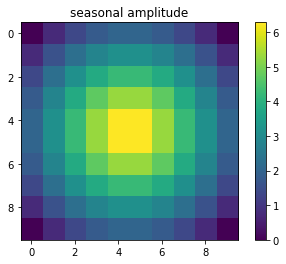

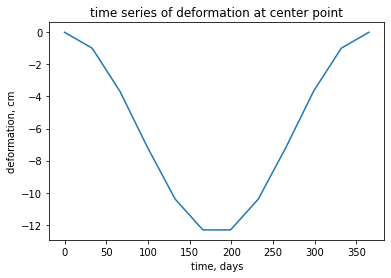

In [2]:
x,y=np.meshgrid(np.linspace(-5,5,10),np.linspace(-5,5,10))
amp=np.sqrt(np.square(x)+np.square(y))
amp=-1*(amp-np.max(amp))
plt.figure();plt.imshow(amp);plt.colorbar();plt.title('seasonal amplitude')
t=np.linspace(0,365,12)
pos=np.zeros((amp.shape[0],amp.shape[1],len(t)))

for xx in range(len(x)):
  for yy in range(len(y)):
    pos[yy,xx,:]=amp[yy,xx]*np.cos(2*np.pi*t/(365))
    pos[yy,xx,:]=pos[yy,xx,:]-amp[yy,xx]

plt.figure();plt.plot(t,pos[5,5,:]);plt.title('time series of deformation at center point')
plt.ylabel('deformation, cm');plt.xlabel('time, days')

Now we will generate some interferograms from our synthetic data. Again, this part is not important to understand, we're just making fake data.

In [3]:
nigramsperscene=3
nigrams=nigramsperscene*len(t)-nigramsperscene*2
igrams=np.zeros((amp.shape[0],amp.shape[1],nigrams))
igramlist=np.zeros((nigrams,2))
count=0
for kk in range(0,len(t)):
  for ii in range(1,nigramsperscene+1):
      if kk+ii<len(t):
        igramlist[count,0]=kk
        igramlist[count,1]=kk+ii 
        igrams[:,:,count]=pos[:,:,kk+ii]-pos[:,:,kk]
        count+=1
print(igramlist)

[[ 0.  1.]
 [ 0.  2.]
 [ 0.  3.]
 [ 1.  2.]
 [ 1.  3.]
 [ 1.  4.]
 [ 2.  3.]
 [ 2.  4.]
 [ 2.  5.]
 [ 3.  4.]
 [ 3.  5.]
 [ 3.  6.]
 [ 4.  5.]
 [ 4.  6.]
 [ 4.  7.]
 [ 5.  6.]
 [ 5.  7.]
 [ 5.  8.]
 [ 6.  7.]
 [ 6.  8.]
 [ 6.  9.]
 [ 7.  8.]
 [ 7.  9.]
 [ 7. 10.]
 [ 8.  9.]
 [ 8. 10.]
 [ 8. 11.]
 [ 9. 10.]
 [ 9. 11.]
 [10. 11.]]


We will add some noise to our interferograms, since there is always some measurement error. Assuming our units are in cm, we'll simulate normally distributed noise with a standard deviation of 1 cm.

In [4]:
igrams=igrams+np.random.normal(0,1,igrams.shape)

Plot first 25 interferograms

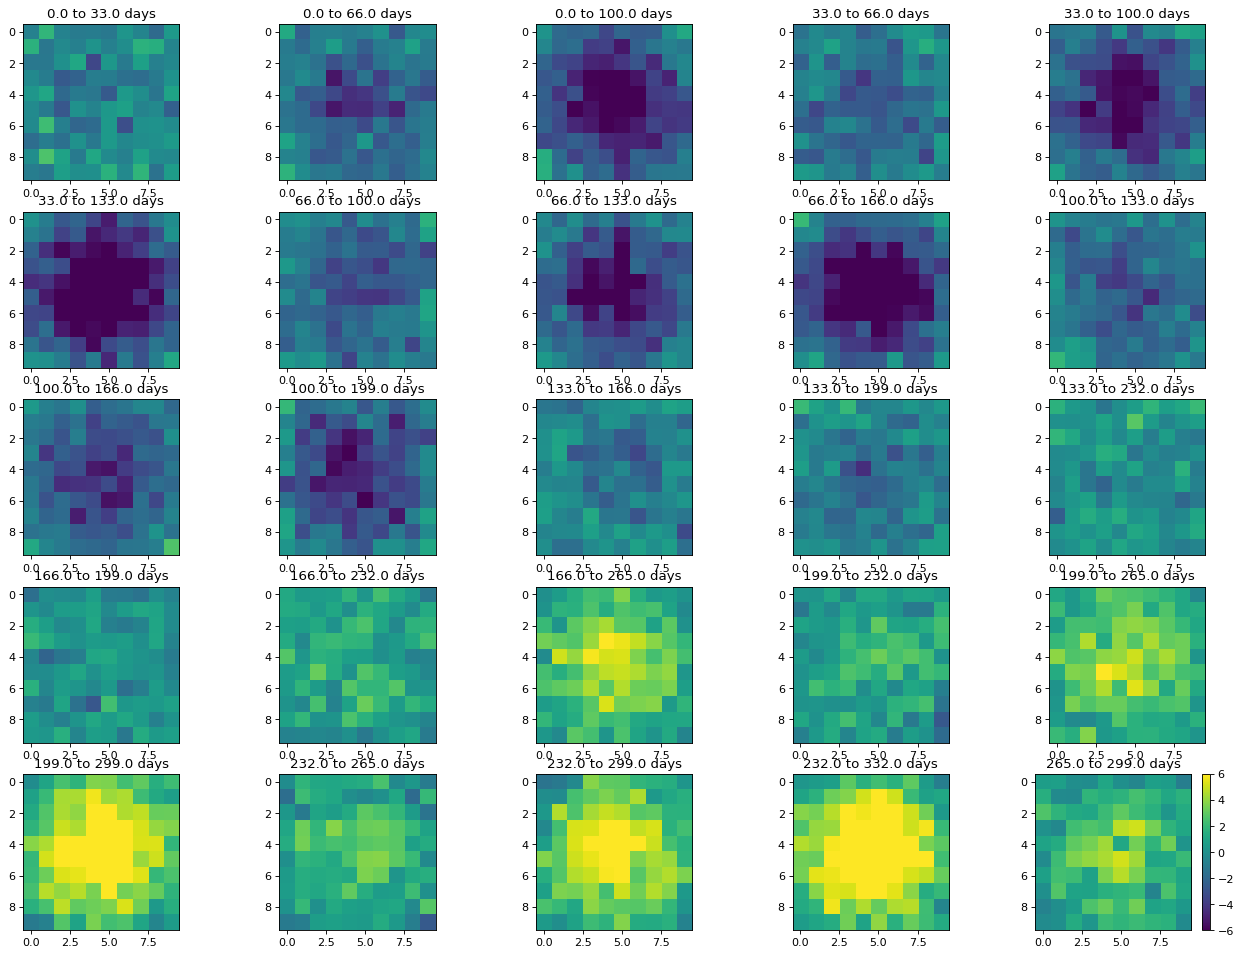

In [5]:
plt.figure(figsize=(20, 15), dpi=80);
for kk in range(25):
  plt.subplot(5,5,kk+1)
  plt.imshow(np.squeeze(igrams[:,:,kk]),vmin=-6,vmax=6);
  text=str(np.round(t[int(igramlist[kk,0])]))+' to '+str(np.round(t[int(igramlist[kk,1])]))+' days'
  plt.title(text)

plt.colorbar()

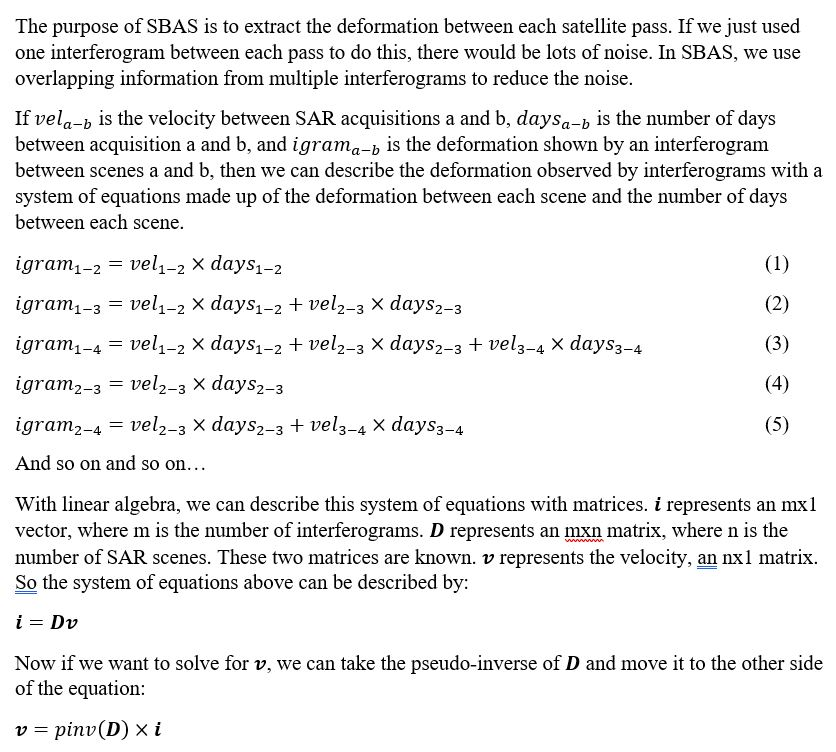


First, we'll make the matrix for **d**, and call it d_mat. We'll plot it with imshow to give you an idea of what it should look like.

(30, 11)


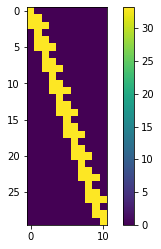

In [6]:
m=igramlist.shape[0]
n=len(t)-1
d_mat=np.zeros((m,n))
days_bw_acq=np.diff(t)
print(d_mat.shape)
for kk in range(m):
  i1=int(igramlist[kk,0])
  i2=int(igramlist[kk,1])
  for tt in range(i2-i1):
    d_mat[kk,tt+i1]=days_bw_acq[tt+i1]
plt.figure();plt.imshow(d_mat);plt.colorbar()

Now, we will implement SBAS and solve for v by by solving the system of equations at every pixel.

In [7]:
velocity_mat=np.zeros((len(y),len(x),n))
for xx in range(len(x)):
  for yy in range(len(y)):
    i=np.matrix(igrams[yy,xx,:].reshape((m,1)))
    pinv_d_mat=np.matrix(np.linalg.pinv(d_mat))
    v=pinv_d_mat*i
    velocity_mat[yy,xx,:]=np.squeeze(v)

Now all we have to do is integrate the velocity to get the relative position at each pixel!

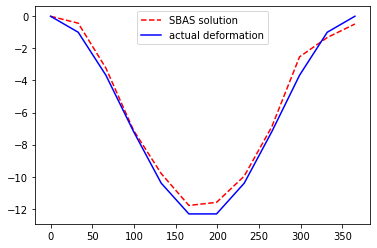

In [8]:
pos_solution=np.zeros((len(y),len(x),len(t)))

for xx in range(len(x)):
  for yy in range(len(y)):
    for tt in range(1,len(t)):
      pos_solution[yy,xx,tt]=pos_solution[yy,xx,tt-1]+velocity_mat[yy,xx,tt-1]*days_bw_acq[tt-1]

plt.figure();plt.plot(t,pos_solution[5,5,:],'r--')
plt.plot(t,pos[5,5,:],'b')
plt.legend(['SBAS solution','actual deformation'])

Looks like our solution matches the data pretty well. Now, let's say that we didn't want to use all those interferograms to solve for velocity, and only use the interferograms that are made from successive satellite passes (e.g. from pass 1 to 2, then 2 to 3, then 3 to 4, etc.)

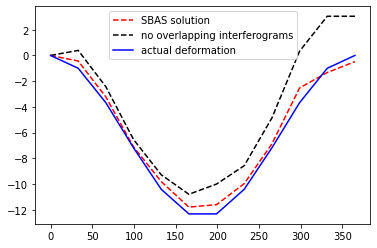

In [9]:
velocity_mat_test=np.zeros((len(y),len(x),n))
d_mat_test=d_mat[0::3,:]
m=d_mat_test.shape[0]

for xx in range(len(x)):
  for yy in range(len(y)):
    i=np.matrix(igrams[yy,xx,0::3].reshape((m,1)))
    pinv_d_mat=np.matrix(np.linalg.pinv(d_mat_test))
    v=pinv_d_mat*i
    velocity_mat_test[yy,xx,:]=np.squeeze(v)

pos_solution_test=np.zeros((len(y),len(x),len(t)))

for xx in range(len(x)):
  for yy in range(len(y)):
    for tt in range(1,len(t)):
      pos_solution_test[yy,xx,tt]=pos_solution_test[yy,xx,tt-1]+velocity_mat_test[yy,xx,tt-1]*days_bw_acq[tt-1]

plt.figure();plt.plot(t,pos_solution[5,5,:],'r--')
plt.plot(t,pos_solution_test[5,5,:],'k--')
plt.plot(t,pos[5,5,:],'b')
plt.legend(['SBAS solution','no overlapping interferograms','actual deformation'])

Most of the time, the full SBAS solution with overlapping interferograms does significantly better at characterizing the true deformation.

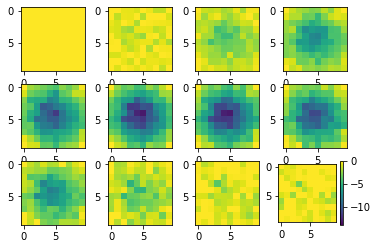

In [10]:
plt.figure()
for kk in range(pos_solution.shape[2]):
  plt.subplot(3,4,kk+1)
  plt.imshow(np.squeeze(pos_solution[:,:,kk]),vmin=-14,vmax=0)
plt.colorbar()